In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, GlobalAveragePooling1D, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Define file paths
base = "/content/drive/MyDrive/county data/"

files = {
    "yield": f"{base}YIELD_COUNTY_US.csv",
    "crop_area": f"{base}CROP_AREA_COUNTY_US.csv",
    "cssf": f"{base}CSSF_COUNTY_US.csv",
    "meteo": f"{base}METEO_COUNTY_US.csv",
    "remote": f"{base}REMOTE_SENSING_COUNTY_US.csv",
    "soil": f"{base}SOIL_COUNTY_US.csv"
}

step-1: loading the data

In [4]:
# Load all CSVs
dfs = {name: pd.read_csv(path) for name, path in files.items()}

# Display shapes
for name, df in dfs.items():
    print(f"{name.upper():15} → {df.shape}")


YIELD           → (45499, 3)
CROP_AREA       → (34013, 4)
CSSF            → (396748, 6)
METEO           → (577980, 11)
REMOTE          → (577980, 4)
SOIL            → (917, 3)


In [5]:
for name, df in dfs.items():
    print(f"--- Head of {name.upper()} ---")
    print(df.head())
    print("\n")

--- Head of YIELD ---
    COUNTY_ID  FYEAR  YIELD
0  AL_AUTAUGA   2018  165.6
1   AL_DALLAS   2018  137.3
2   AL_ELMORE   2018  170.5
3    AL_PERRY   2018  145.2
4  AL_BALDWIN   2018  152.0


--- Head of CROP_AREA ---
    COUNTY_ID  FYEAR  CROP_AREA  TOTAL_AREA
0  AL_AUTAUGA   2018        900   380443.97
1  AL_AUTAUGA   2017        650   380443.97
2  AL_AUTAUGA   2013       1400   380443.97
3  AL_AUTAUGA   2011       1040   380443.97
4  AL_AUTAUGA   2007       1500   380443.97


--- Head of CSSF ---
     COUNTY_ID  FYEAR  DEKAD         TAGP  TWSO       DVS
0  AL_LAWRENCE   2000     14   328.019315   0.0  0.048025
1  AL_LAWRENCE   2000     15  1222.327979   0.0  0.172422
2  AL_LAWRENCE   2000     16  2235.543407   0.0  0.286407
3  AL_LAWRENCE   2000     17  3223.747223   0.0  0.416780
4  AL_LAWRENCE   2000     18  4604.340642   0.0  0.547286


--- Head of METEO ---
     COUNTY_ID  FYEAR  DEKAD      TMAX     TMIN     TAVG     VPRES     WSPD  \
0  AL_LAWRENCE   2000      1  19.83040 -2.33

step 2: TRANSFORM: aggregate & merge to yearly county-level

In [6]:
# Merge yield + crop_area (year-level)
merged = dfs['yield'].merge(dfs['crop_area'], on=['COUNTY_ID','FYEAR'], how='left')

# Aggregate cssf, meteo, remote to year-level (mean)
cssf_yearly = dfs['cssf'].groupby(['COUNTY_ID','FYEAR']).mean().reset_index()
meteo_yearly = dfs['meteo'].groupby(['COUNTY_ID','FYEAR']).mean().reset_index()
remote_yearly = dfs['remote'].groupby(['COUNTY_ID','FYEAR']).mean().reset_index()
merged = merged.merge(cssf_yearly, on=['COUNTY_ID','FYEAR'], how='left')
merged = merged.merge(meteo_yearly, on=['COUNTY_ID','FYEAR'], how='left')
merged = merged.merge(remote_yearly, on=['COUNTY_ID','FYEAR'], how='left')

# Merge soil (static by COUNTY_ID)
if 'COUNTY_ID' in dfs['soil'].columns:
    merged = merged.merge(dfs['soil'], on='COUNTY_ID', how='left')



In [7]:
print("Merged dataset shape:", merged.shape)
print("Columns (first 40):", merged.columns.tolist()[:40])


Merged dataset shape: (45555, 22)
Columns (first 40): ['COUNTY_ID', 'FYEAR', 'YIELD', 'CROP_AREA', 'TOTAL_AREA', 'DEKAD_x', 'TAGP', 'TWSO', 'DVS', 'DEKAD_y', 'TMAX', 'TMIN', 'TAVG', 'VPRES', 'WSPD', 'PREC', 'ET0', 'RAD', 'DEKAD', 'FAPAR', 'SM_WHC', 'SM_DEPTH']


In [8]:
# Check shape before removing NaN values
print(f"Before cleaning: {merged.shape[0]:,} rows, {merged.shape[1]:,} columns")

# Remove rows with NaN values
merged = merged.dropna()

# Check shape after cleaning
print(f"After removing NaN values: {merged.shape[0]:,} rows, {merged.shape[1]:,} columns")

# Save cleaned dataset
merged.to_csv("/content/drive/MyDrive/county data/merged_county_dataset_yearly.csv", index=False)
print("💾 Cleaned dataset saved as 'merged_county_dataset_yearly.csv'")


Before cleaning: 45,555 rows, 22 columns
After removing NaN values: 16,055 rows, 22 columns
💾 Cleaned dataset saved as 'merged_county_dataset_yearly.csv'


In [9]:
# Save merged intermediate dataset
merged_path = os.path.join(base, "merged_county_dataset_yearly.csv")
merged.to_csv(merged_path, index=False)
print(f"Saved merged dataset to: {merged_path}\n")


Saved merged dataset to: /content/drive/MyDrive/county data/merged_county_dataset_yearly.csv



In [10]:
merged.head(5)

,COUNTY_ID,FYEAR,YIELD,CROP_AREA,TOTAL_AREA,DEKAD_x,TAGP,TWSO,DVS,DEKAD_y,...,TAVG,VPRES,WSPD,PREC,ET0,RAD,DEKAD,FAPAR,SM_WHC,SM_DEPTH
8,AL_CALHOUN,2018,156.2,1300.0,387755.20,25.0,18442.656959,5477.829868,1.321064,18.5,...,16.920632,15.781751,2.675759,40.570184,31.708778,158374.616536,18.5,0.611799,11.104716,100.0
12,AL_COLBERT,2018,153.6,16500.0,379356.76,25.0,13818.235017,4284.534246,1.346041,18.5,...,16.640940,15.821839,2.729526,44.877016,31.643611,157573.786241,18.5,0.452033,11.548404,100.0
14,AL_LAUDERDALE,2018,165.3,18600.0,427528.41,25.0,14134.176412,4219.309413,1.347137,18.5,...,16.543739,15.722385,2.713381,46.231373,31.495111,156940.613932,18.5,0.447170,11.968489,100.0
15,AL_LAWRENCE,2018,176.9,25500.0,442037.98,25.0,14987.168320,4511.305939,1.353369,18.5,...,16.613945,15.663007,2.793129,41.307310,31.872533,158003.610894,18.5,0.452894,11.810490,100.0
21,AL_TALLADEGA,2018,139.2,6250.0,471540.56,23.5,17461.052651,5698.522172,1.294238,18.5,...,17.426592,16.233227,2.770090,41.232328,32.478525,160601.325087,18.5,0.544382,11.580876,100.0


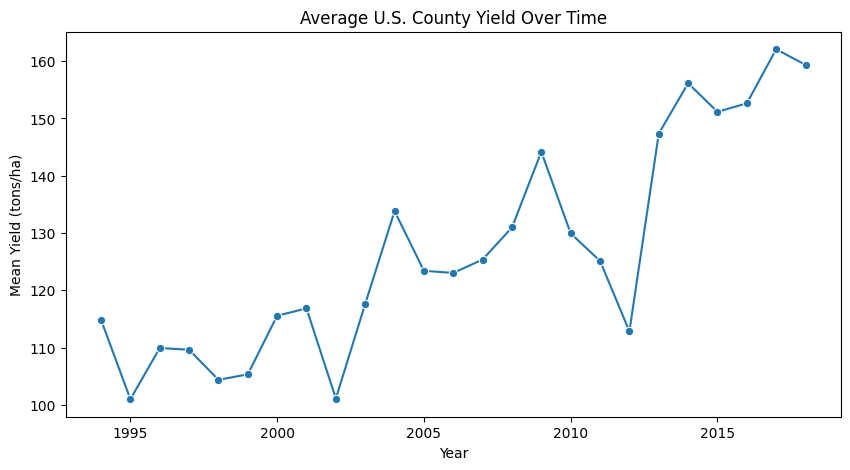

In [11]:
import seaborn as sns
# Average yield per year
yield_trend = dfs["yield"].groupby("FYEAR")["YIELD"].mean().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(data=yield_trend, x="FYEAR", y="YIELD", marker='o')
plt.title("Average U.S. County Yield Over Time")
plt.ylabel("Mean Yield (tons/ha)")
plt.xlabel("Year")
plt.show()

Loaded 'data' from CSV for correlation plot.


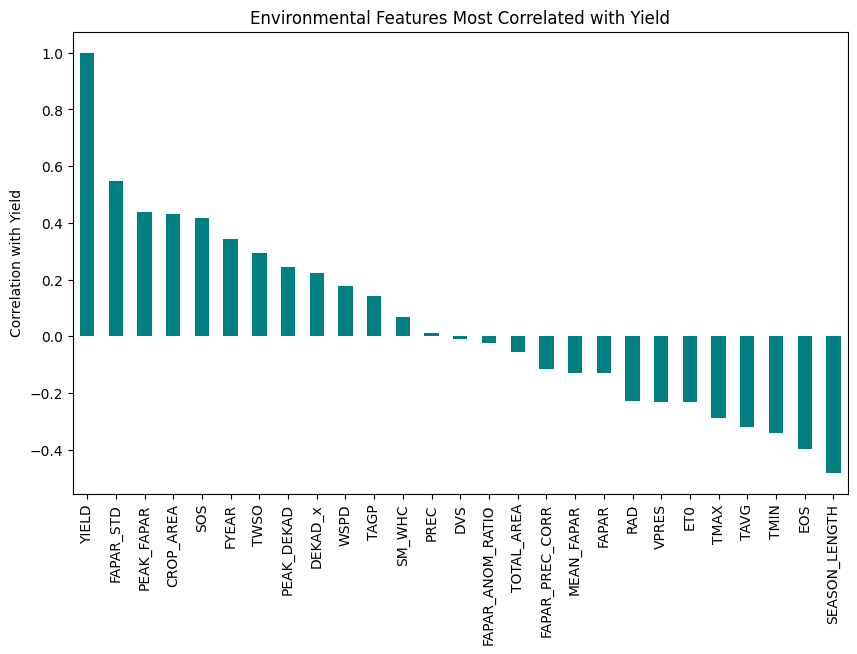

In [12]:
import pandas as pd
import os

# Ensure base path is defined, similar to other cells
base = "/content/drive/MyDrive/county data/"
final_county_path = os.path.join(base, "final_county_dataset.csv")

# Check if 'data' DataFrame is already defined, if not, load it.
if 'data' not in locals() and 'data' not in globals():
    try:
        data = pd.read_csv(final_county_path)
        print("Loaded 'data' from CSV for correlation plot.")
    except FileNotFoundError:
        print(f"Error: {final_county_path} not found. Please ensure all previous data processing steps have been executed.")
        raise # Re-raise the error if the file is genuinely missing

corr = data.corr(numeric_only=True)
corr_with_yield = corr['YIELD'].dropna().sort_values(ascending=False)
plt.figure(figsize=(10,6))
corr_with_yield.plot(kind='bar', color='teal')
plt.title("Environmental Features Most Correlated with Yield")
plt.ylabel("Correlation with Yield")
plt.show()

In [13]:
corr_with_yield = corr['YIELD'].sort_values(ascending=False)
print(corr_with_yield.head(10))
print(corr_with_yield.tail(10))

YIELD         1.000000
FAPAR_STD     0.546929
PEAK_FAPAR    0.438175
CROP_AREA     0.432064
SOS           0.418757
FYEAR         0.342681
TWSO          0.294113
PEAK_DEKAD    0.243041
DEKAD_x       0.222007
WSPD          0.176550
Name: YIELD, dtype: float64
VPRES           -0.232535
ET0             -0.233740
TMAX            -0.289496
TAVG            -0.318933
TMIN            -0.339737
EOS             -0.397657
SEASON_LENGTH   -0.481704
DEKAD_y               NaN
DEKAD                 NaN
SM_DEPTH              NaN
Name: YIELD, dtype: float64


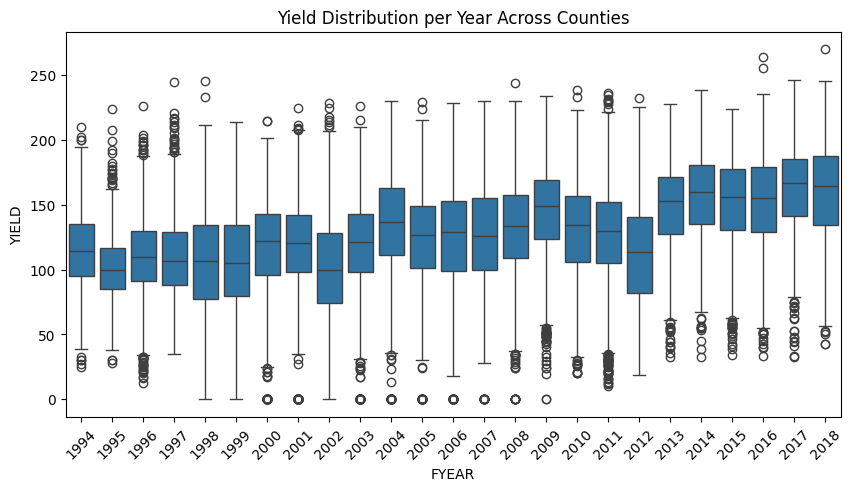

In [14]:
plt.figure(figsize=(10,5))
sns.boxplot(x="FYEAR", y="YIELD", data=dfs["yield"])
plt.title("Yield Distribution per Year Across Counties")
plt.xticks(rotation=45)
plt.show()

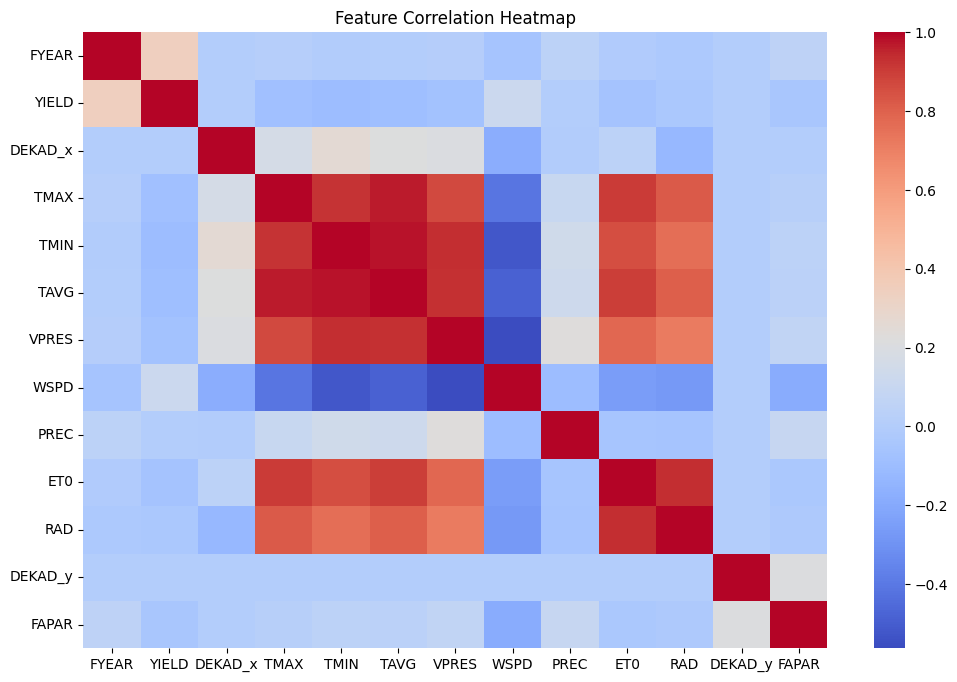

In [15]:
# Example merged subset
merged = dfs["yield"].merge(dfs["meteo"], on=["COUNTY_ID","FYEAR"], how="left")
merged = merged.merge(dfs["remote"], on=["COUNTY_ID","FYEAR"], how="left")

corr = merged.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

### Derived features: phenology + irrigation proxies

In [16]:
# --- Step 1: Compute phenology metrics per county-year ---
def compute_phenology(df, fapar_col="FAPAR", time_col="DEKAD"):
    df = df.sort_values([time_col])

    # Normalize FAPAR
    df["fapar_norm"] = (df[fapar_col] - df[fapar_col].min()) / (df[fapar_col].max() - df[fapar_col].min())

    max_row = df.loc[df[fapar_col].idxmax()]
    start = df.loc[df["fapar_norm"] > 0.2, time_col].min()
    end = df.loc[df["fapar_norm"] > 0.2, time_col].max()
    peak_doy = max_row[time_col]
    peak_value = max_row[fapar_col]

    return pd.Series({
        "SOS": start,
        "EOS": end,
        "SEASON_LENGTH": end - start if pd.notnull(end) and pd.notnull(start) else np.nan,
        "PEAK_DEKAD": peak_doy,
        "PEAK_FAPAR": peak_value,
        "MEAN_FAPAR": df[fapar_col].mean(),
        "FAPAR_STD": df[fapar_col].std()
    })

phenology = dfs['remote'].groupby(["COUNTY_ID","FYEAR"]).apply(compute_phenology).reset_index()
print("Phenology metrics:")
print(phenology.head())

# --- Step 2: Compute irrigation proxy ---
# Merge by COUNTY_ID, FYEAR, DEKAD
merged = pd.merge(dfs['remote'], dfs['meteo'], on=["COUNTY_ID","FYEAR","DEKAD"], how="inner")

def irrigation_proxy(df, fapar_col="FAPAR", prec_col="PREC"):
    if len(df) < 4:
        return pd.Series({"FAPAR_PREC_CORR": np.nan, "FAPAR_ANOM_RATIO": np.nan})

    corr = df[fapar_col].corr(df[prec_col])
    median_prec = df[prec_col].median()
    dry_mean = df.loc[df[prec_col] < median_prec, fapar_col].mean()
    wet_mean = df.loc[df[prec_col] >= median_prec, fapar_col].mean()
    ratio = dry_mean / wet_mean if wet_mean != 0 else np.nan

    return pd.Series({
        "FAPAR_PREC_CORR": corr,
        "FAPAR_ANOM_RATIO": ratio
    })

irrig = merged.groupby(["COUNTY_ID","FYEAR"]).apply(irrigation_proxy).reset_index()
print("\nIrrigation proxies:")
print(irrig.head())

# --- Step 3: Merge results ---
enhanced = phenology.merge(irrig, on=["COUNTY_ID","FYEAR"], how="left")
enhanced.to_csv("/content/drive/MyDrive/county data/phenology_irrigation_features.csv", index=False)

print("\n Saved derived features to /content/drive/MyDrive/county data/phenology_irrigation_features.csv")

/tmp/ipython-input-2875433754.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  phenology = dfs['remote'].groupby(["COUNTY_ID","FYEAR"]).apply(compute_phenology).reset_index()


Phenology metrics:
    COUNTY_ID  FYEAR  SOS   EOS  SEASON_LENGTH  PEAK_DEKAD  PEAK_FAPAR  \
0  AL_CALHOUN   2002  9.0  36.0           27.0        13.0     0.76125   
1  AL_CALHOUN   2003  8.0  32.0           24.0        18.0     0.76800   
2  AL_CALHOUN   2004  9.0  35.0           26.0        21.0     0.79675   
3  AL_CALHOUN   2006  7.0  36.0           29.0        13.0     0.77175   
4  AL_CALHOUN   2007  1.0  31.0           30.0        21.0     0.75175   

   MEAN_FAPAR  FAPAR_STD  
0    0.544000   0.141558  
1    0.556062   0.168978  
2    0.564021   0.180220  
3    0.537965   0.144189  
4    0.530160   0.121464  


/tmp/ipython-input-2875433754.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  irrig = merged.groupby(["COUNTY_ID","FYEAR"]).apply(irrigation_proxy).reset_index()



Irrigation proxies:
    COUNTY_ID  FYEAR  FAPAR_PREC_CORR  FAPAR_ANOM_RATIO
0  AL_CALHOUN   2002         0.115987          0.990750
1  AL_CALHOUN   2003         0.399539          0.855474
2  AL_CALHOUN   2004         0.303738          0.934154
3  AL_CALHOUN   2006        -0.227004          1.091724
4  AL_CALHOUN   2007         0.103022          0.978721

 Saved derived features to /content/drive/MyDrive/county data/phenology_irrigation_features.csv


In [17]:
enhanced.head(5)

,COUNTY_ID,FYEAR,SOS,EOS,SEASON_LENGTH,PEAK_DEKAD,PEAK_FAPAR,MEAN_FAPAR,FAPAR_STD,FAPAR_PREC_CORR,FAPAR_ANOM_RATIO
0,AL_CALHOUN,2002,9.0,36.0,27.0,13.0,0.76125,0.544000,0.141558,0.115987,0.990750
1,AL_CALHOUN,2003,8.0,32.0,24.0,18.0,0.76800,0.556062,0.168978,0.399539,0.855474
2,AL_CALHOUN,2004,9.0,35.0,26.0,21.0,0.79675,0.564021,0.180220,0.303738,0.934154
3,AL_CALHOUN,2006,7.0,36.0,29.0,13.0,0.77175,0.537965,0.144189,-0.227004,1.091724
4,AL_CALHOUN,2007,1.0,31.0,30.0,21.0,0.75175,0.530160,0.121464,0.103022,0.978721


step 3: LOAD-Assemble final dataset for analysis/modeling

In [18]:
# MERGE ENHANCED -> FINAL county-level dataset
# -------------------------
import os

# Ensure base is defined from previous steps
# If 'base' is not defined here, it would need to be passed or re-initialized.
# Assuming 'base' is available from the global scope after previous cell executions.
base = "/content/drive/MyDrive/county data/"
merged_path = os.path.join(base, "merged_county_dataset_yearly.csv")
phenology_path = os.path.join(base, "phenology_irrigation_features.csv")

df = pd.read_csv(merged_path)
enhanced_df = pd.read_csv(phenology_path)
data = df.merge(enhanced_df, on=["COUNTY_ID","FYEAR"], how="left")
print("Final combined data shape:", data.shape)
print(data.columns.tolist()[:50])

Final combined data shape: (16055, 31)
['COUNTY_ID', 'FYEAR', 'YIELD', 'CROP_AREA', 'TOTAL_AREA', 'DEKAD_x', 'TAGP', 'TWSO', 'DVS', 'DEKAD_y', 'TMAX', 'TMIN', 'TAVG', 'VPRES', 'WSPD', 'PREC', 'ET0', 'RAD', 'DEKAD', 'FAPAR', 'SM_WHC', 'SM_DEPTH', 'SOS', 'EOS', 'SEASON_LENGTH', 'PEAK_DEKAD', 'PEAK_FAPAR', 'MEAN_FAPAR', 'FAPAR_STD', 'FAPAR_PREC_CORR', 'FAPAR_ANOM_RATIO']


In [19]:
# Save final county-level dataset
final_county_path = os.path.join(base, "final_county_dataset.csv")
data.to_csv(final_county_path, index=False)
print("Saved final county dataset:", final_county_path)


Saved final county dataset: /content/drive/MyDrive/county data/final_county_dataset.csv


In [20]:
data.head(5)

,COUNTY_ID,FYEAR,YIELD,CROP_AREA,TOTAL_AREA,DEKAD_x,TAGP,TWSO,DVS,DEKAD_y,...,SM_DEPTH,SOS,EOS,SEASON_LENGTH,PEAK_DEKAD,PEAK_FAPAR,MEAN_FAPAR,FAPAR_STD,FAPAR_PREC_CORR,FAPAR_ANOM_RATIO
0,AL_CALHOUN,2018,156.2,1300.0,387755.20,25.0,18442.656959,5477.829868,1.321064,18.5,...,100.0,7.0,33.0,26.0,18.0,0.851500,0.611799,0.166205,-0.142570,1.018443
1,AL_COLBERT,2018,153.6,16500.0,379356.76,25.0,13818.235017,4284.534246,1.346041,18.5,...,100.0,5.0,31.0,26.0,19.0,0.664302,0.452033,0.121689,-0.221402,1.078630
2,AL_LAUDERDALE,2018,165.3,18600.0,427528.41,25.0,14134.176412,4219.309413,1.347137,18.5,...,100.0,5.0,31.0,26.0,19.0,0.688282,0.447170,0.125661,-0.273467,1.130194
3,AL_LAWRENCE,2018,176.9,25500.0,442037.98,25.0,14987.168320,4511.305939,1.353369,18.5,...,100.0,6.0,28.0,22.0,19.0,0.747077,0.452894,0.142261,-0.269006,1.102462
4,AL_TALLADEGA,2018,139.2,6250.0,471540.56,23.5,17461.052651,5698.522172,1.294238,18.5,...,100.0,6.0,33.0,27.0,20.0,0.788741,0.544382,0.136473,-0.040020,0.945334


In [21]:
data.describe()

,FYEAR,YIELD,CROP_AREA,TOTAL_AREA,DEKAD_x,TAGP,TWSO,DVS,DEKAD_y,TMAX,...,SM_DEPTH,SOS,EOS,SEASON_LENGTH,PEAK_DEKAD,PEAK_FAPAR,MEAN_FAPAR,FAPAR_STD,FAPAR_PREC_CORR,FAPAR_ANOM_RATIO
count,16055.000000,16055.000000,16055.000000,1.605500e+04,16055.000000,16055.000000,16055.000000,16055.000000,16055.0,16055.000000,...,16055.0,16055.000000,16055.000000,16055.000000,16055.000000,16055.000000,16055.000000,16055.000000,16055.000000,16055.000000
mean,2008.646403,145.456126,69303.530987,3.890338e+05,24.144098,14707.015460,5246.186722,1.332131,18.5,23.178147,...,100.0,10.702834,30.546808,19.843974,20.994021,0.755508,0.375883,0.204657,0.082253,0.931332
std,5.431876,35.824614,59273.298232,2.010352e+05,1.194918,3060.411064,1098.879102,0.080793,0.0,2.940889,...,0.0,3.115536,2.897469,5.100327,2.411449,0.129256,0.079299,0.055258,0.190464,0.215175
min,2000.000000,19.000000,100.000000,8.270243e+04,20.500000,1344.151439,432.930959,0.957623,18.5,14.441124,...,100.0,1.000000,14.000000,8.000000,9.000000,0.174864,0.092052,0.033987,-0.478330,0.304381
25%,2004.000000,124.800000,22500.000000,2.745564e+05,23.500000,13466.351922,4785.759969,1.282311,18.5,21.021845,...,100.0,9.000000,28.000000,16.000000,20.000000,0.705994,0.321395,0.167776,-0.051589,0.792389
50%,2008.000000,149.300000,55000.000000,3.602187e+05,25.000000,15253.049563,5451.809701,1.330926,18.5,23.085834,...,100.0,11.000000,30.000000,19.000000,21.000000,0.797451,0.376303,0.212284,0.079394,0.910881
75%,2013.000000,170.900000,100000.000000,4.509831e+05,25.000000,16742.244540,5976.526646,1.372717,18.5,25.077425,...,100.0,12.000000,33.000000,23.000000,22.000000,0.848535,0.429801,0.247506,0.206393,1.050128
max,2018.000000,246.700000,394000.000000,2.551058e+06,28.000000,22935.126241,8045.222676,1.655194,18.5,31.686970,...,100.0,22.000000,36.000000,35.000000,33.000000,0.924914,0.621111,0.309362,0.752694,2.453858


In [22]:
# BUILD STATE-LEVEL AGGREGATION
# -------------------------
print("Creating state-level aggregated dataset...")

# Add STATE field (assumes COUNTY_ID begins with STATE code like 'XX_...')
if "COUNTY_ID" in data.columns:
    data["STATE"] = data["COUNTY_ID"].astype(str).str.split("_").str[0]
else:
    data["STATE"] = "UNK"

# Choose numeric columns to aggregate
agg_cols = data.select_dtypes(include=[np.number]).columns.tolist()
# keep YIELD in aggregation
if "YIELD" not in agg_cols and "YIELD" in data.columns:
    agg_cols.append("YIELD")
# Exclude 'FYEAR' from the aggregation columns as it's a grouping column
agg_cols = [col for col in agg_cols if col != 'FYEAR']
# groupby STATE, FYEAR and take mean
state_level = data.groupby(["STATE","FYEAR"])[agg_cols].mean().reset_index()
state_path = os.path.join(base, "state_level_dataset.csv")
state_level.to_csv(state_path, index=False)
print("Saved state-level dataset:", state_path, "shape:", state_level.shape)


Creating state-level aggregated dataset...
Saved state-level dataset: /content/drive/MyDrive/county data/state_level_dataset.csv shape: (454, 31)


In [23]:
state_level.head(5)

,STATE,FYEAR,YIELD,CROP_AREA,TOTAL_AREA,DEKAD_x,TAGP,TWSO,DVS,DEKAD_y,...,SM_DEPTH,SOS,EOS,SEASON_LENGTH,PEAK_DEKAD,PEAK_FAPAR,MEAN_FAPAR,FAPAR_STD,FAPAR_PREC_CORR,FAPAR_ANOM_RATIO
0,AL,2000,80.500000,7400.000000,430115.927500,24.625,14082.098155,3935.414365,1.327635,18.5,...,100.0,2.500000,29.250000,26.750000,18.500000,0.631156,0.382780,0.125315,0.025846,0.948613
1,AL,2001,115.250000,4875.000000,437890.842500,24.625,15213.506610,4670.446469,1.251072,18.5,...,100.0,7.500000,33.750000,26.250000,22.250000,0.678664,0.418621,0.159620,0.157661,0.874817
2,AL,2002,100.166667,5333.333333,435143.188333,24.500,14900.856938,4273.771093,1.292886,18.5,...,100.0,9.500000,34.000000,24.500000,18.500000,0.703204,0.458097,0.131263,0.253601,0.904895
3,AL,2003,131.166667,6183.333333,435143.188333,24.500,16556.727605,4851.796859,1.245868,18.5,...,100.0,6.166667,32.333333,26.166667,20.166667,0.730579,0.475041,0.155082,0.370631,0.844409
4,AL,2004,140.400000,7680.000000,421643.782000,24.700,17264.463006,5364.844226,1.292221,18.5,...,100.0,10.200000,33.800000,23.600000,20.600000,0.775856,0.475608,0.171997,0.194234,0.956878


In [24]:
state_level.shape

(454, 31)

In [25]:
display(state_level.describe())

,FYEAR,YIELD,CROP_AREA,TOTAL_AREA,DEKAD_x,TAGP,TWSO,DVS,DEKAD_y,TMAX,...,SM_DEPTH,SOS,EOS,SEASON_LENGTH,PEAK_DEKAD,PEAK_FAPAR,MEAN_FAPAR,FAPAR_STD,FAPAR_PREC_CORR,FAPAR_ANOM_RATIO
count,454.000000,454.000000,454.000000,4.540000e+02,454.000000,454.000000,454.000000,454.000000,454.0,454.000000,...,454.0,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000
mean,2008.984581,138.229239,51453.931225,4.488762e+05,23.766584,14376.312274,5174.329771,1.349285,18.5,24.315768,...,100.0,9.691335,31.094738,21.403404,20.815367,0.729879,0.396237,0.182407,0.119875,0.920637
std,5.487874,28.666061,41677.588032,2.420076e+05,1.235415,2981.611938,1067.012167,0.064732,0.0,3.416327,...,0.0,2.897847,2.078286,4.035010,1.883032,0.119750,0.082838,0.051846,0.193618,0.159569
min,2000.000000,46.200000,4100.000000,2.267581e+05,20.593750,2673.237312,1113.230656,1.196506,18.5,17.011453,...,100.0,1.000000,26.117647,12.647059,12.000000,0.261226,0.147959,0.052216,-0.411234,0.454198
25%,2004.000000,120.873852,18298.684211,3.163721e+05,23.314817,13248.543360,4827.400704,1.308828,18.5,21.592834,...,100.0,8.059743,29.469688,18.405263,20.129902,0.687296,0.331341,0.137965,-0.014273,0.815036
50%,2009.000000,138.019048,37593.237454,4.045585e+05,24.250000,15215.665383,5461.340662,1.342993,18.5,24.579259,...,100.0,10.061057,30.828431,21.273148,21.200000,0.757099,0.405641,0.181526,0.109600,0.908454
75%,2014.000000,159.591964,74600.061920,4.550680e+05,24.700000,16383.717147,5873.995705,1.375044,18.5,27.396078,...,100.0,11.696875,32.410000,24.073529,21.981823,0.820575,0.456798,0.222650,0.229297,1.014497
max,2018.000000,204.282716,165764.705882,1.746992e+06,25.000000,19540.425822,7200.190237,1.622940,18.5,30.266130,...,100.0,15.176471,36.000000,35.000000,25.000000,0.893244,0.556910,0.287288,0.640056,1.562798


Pre-Processing

In [26]:
for col in data.columns:
    if data[col].dtype in ["float64", "int64"]:
        data[col].fillna(data[col].mean(), inplace=True)
    else:
        data[col].fillna(data[col].mode()[0], inplace=True)
# Outlier capping
for col in data.select_dtypes(include=[np.number]).columns:
    Q1, Q3 = data[col].quantile([0.25,0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    data[col] = np.clip(data[col], lower, upper)

# Remove high correlation
corr = data.corr(numeric_only=True)
to_drop = set([b for a in corr.columns for b in corr.columns if a != b and corr.loc[a,b] > 0.9])
data.drop(columns=list(to_drop), inplace=True, errors='ignore')

target = "YIELD"
exclude = ["COUNTY_ID","FYEAR","STATE",target]
X = data.drop(columns=exclude)
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data ready for modeling")



✅ Data ready for modeling


/tmp/ipython-input-341456055.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace=True)
/tmp/ipython-input-341456055.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

Multi-modal in NN model

In [27]:
def build_model(input_dim):
    model = tf.keras.Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

## Consolidate `train_and_evaluate` function definition

### Subtask:
Move all fragmented parts of the `train_and_evaluate` function (including its definition, parameter handling, data preparation, model training, evaluation, saving, plotting, and the return statement) into a single, complete function block within cell `kA0a9C82vtQQ`.


**Reasoning**:
The subtask requires consolidating fragmented parts of the `train_and_evaluate` function into a single, complete block within cell `kA0a9C82vtQQ`. This involves combining code from multiple cells and ensuring all necessary operations are performed within the function.



In [29]:
def train_and_evaluate(data, scope_name, results_dir, do_shap=False):
    target = "YIELD"

    if scope_name == "county":
        exclude = ["COUNTY_ID", "FYEAR", "STATE", target]
    elif scope_name == "state":
        exclude = ["STATE", "FYEAR", target]
    else:
        exclude = ["FYEAR", target]

    X = data.drop(columns=exclude)
    y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = build_model(X_train_scaled.shape[1])
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=50, batch_size=32, verbose=1
    )

    preds = model.predict(X_test_scaled).flatten()

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    print(f"{scope_name.upper()} → MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

    model_path = os.path.join(results_dir, f"nn_{scope_name}_multi_input.keras")
    model.save(model_path)

    return {
        "scope": scope_name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "y_test": y_test.values,
        "preds": preds,
        "history": history
    }
# ---- RUN ----
county_results = train_and_evaluate(data, "county", base)



Epoch 1/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 7206.7080 - mae: 63.4734 - val_loss: 782.4099 - val_mae: 21.8929
Epoch 2/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 747.3823 - mae: 21.3187 - val_loss: 648.1084 - val_mae: 19.9976
Epoch 3/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 668.3083 - mae: 20.3051 - val_loss: 590.5284 - val_mae: 18.9071
Epoch 4/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 620.4202 - mae: 19.3835 - val_loss: 590.9113 - val_mae: 18.4771
Epoch 5/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 618.1994 - mae: 19.4883 - val_loss: 545.9741 - val_mae: 18.2072
Epoch 6/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 579.7054 - mae: 18.7679 - val_loss: 563.1768 - val_mae: 18.6618
Epoch 7/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 564.3558 - mae: 18.6677 - val_loss: 505.8618 - val_mae: 17.3433
Epoch 8/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 553.9500 - mae: 18.3838 - val_loss: 493.8780 - val_mae: 17.1528
Epoch 9

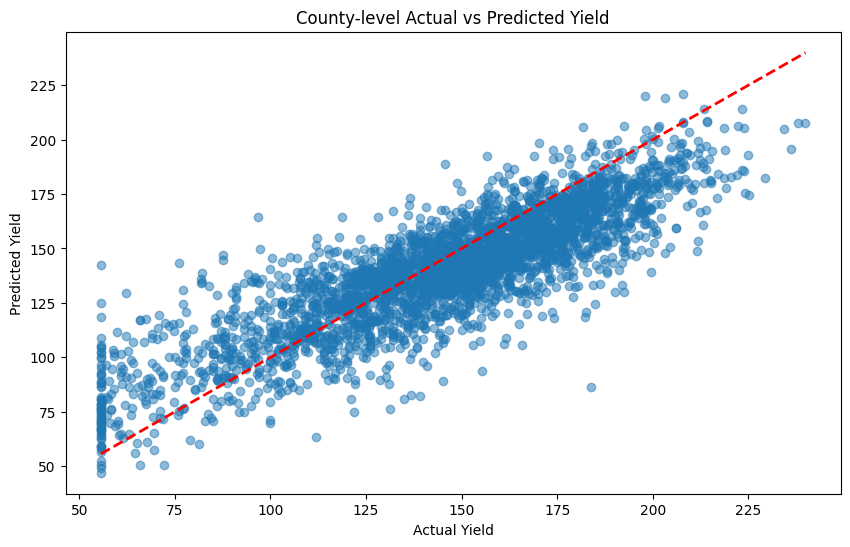

In [30]:
# ---- ACTUAL vs PREDICTED PLOT ----
plt.figure(figsize=(10, 6))
plt.scatter(county_results["y_test"], county_results["preds"], alpha=0.5)
plt.plot(
    [county_results["y_test"].min(), county_results["y_test"].max()],
    [county_results["y_test"].min(), county_results["y_test"].max()],
    "r--", lw=2
)
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("County-level Actual vs Predicted Yield")
plt.show()

In [31]:
# ---- RUN STATE-LEVEL MODEL ----
state_results = train_and_evaluate(state_level, "state", base)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - loss: 18971.1406 - mae: 134.4186 - val_loss: 19024.1602 - val_mae: 135.2240
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 17690.2148 - mae: 130.0375 - val_loss: 14805.7559 - val_mae: 118.6324
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12211.1865 - mae: 106.5698 - val_loss: 6201.1519 - val_mae: 73.0774
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3318.5149 - mae: 50.3654 - val_loss: 1577.0280 - val_mae: 32.1738
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2124.0466 - mae: 36.7754 - val_loss: 1170.6653 - val_mae: 28.1223
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1194.1630 - mae: 27.1002 - val_loss: 1283.8508 - val_mae: 28.0696
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 998.3169 - mae: 24.8817 - val_loss: 997.3858 - val_mae: 25.2293
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 917.2060 - mae: 23.7966 - val_loss: 934.5875 - val_mae: 24.9027


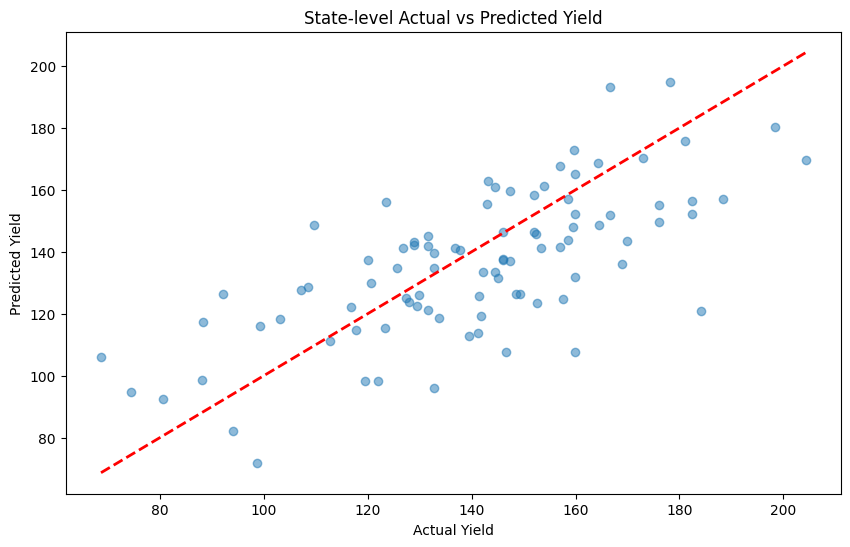

In [32]:
# ---- ACTUAL vs PREDICTED (STATE LEVEL) ----
plt.figure(figsize=(10, 6))
plt.scatter(state_results["y_test"], state_results["preds"], alpha=0.5)

plt.plot(
    [state_results["y_test"].min(), state_results["y_test"].max()],
    [state_results["y_test"].min(), state_results["y_test"].max()],
    "r--", lw=2
)

plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("State-level Actual vs Predicted Yield")
plt.show()

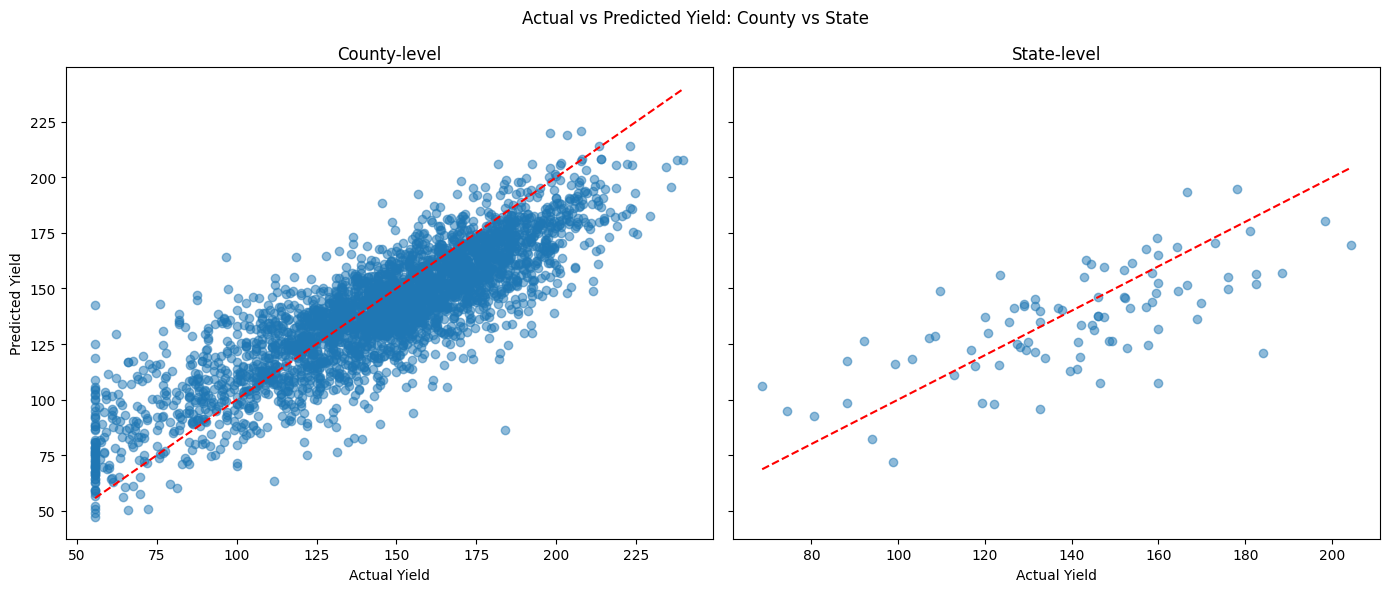

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# County
axes[0].scatter(county_results["y_test"], county_results["preds"], alpha=0.5)
axes[0].plot(
    [county_results["y_test"].min(), county_results["y_test"].max()],
    [county_results["y_test"].min(), county_results["y_test"].max()],
    "r--"
)
axes[0].set_title("County-level")
axes[0].set_xlabel("Actual Yield")
axes[0].set_ylabel("Predicted Yield")

# State
axes[1].scatter(state_results["y_test"], state_results["preds"], alpha=0.5)
axes[1].plot(
    [state_results["y_test"].min(), state_results["y_test"].max()],
    [state_results["y_test"].min(), state_results["y_test"].max()],
    "r--"
)
axes[1].set_title("State-level")
axes[1].set_xlabel("Actual Yield")

plt.suptitle("Actual vs Predicted Yield: County vs State")
plt.tight_layout()
plt.show()


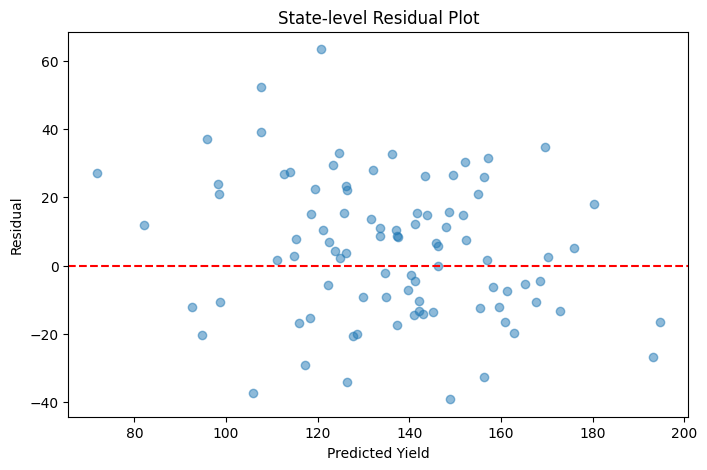

In [34]:
state_residuals = state_results["y_test"] - state_results["preds"]

plt.figure(figsize=(8, 5))
plt.scatter(state_results["preds"], state_residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Yield")
plt.ylabel("Residual")
plt.title("State-level Residual Plot")
plt.show()


In [35]:
print(pd.DataFrame([county_results, state_results]))

    scope        MAE       RMSE        R2  \
0  county  15.281566  19.456148  0.697039   
1   state  16.940032  20.653783  0.427386   

                                              y_test  \
0  [110.0, 162.0, 154.0, 174.0, 86.2, 162.3, 159....   
1  [176.02987012987012, 127.3, 159.95, 158.613333...   

                                               preds  \
0  [108.814026, 152.14793, 154.2371, 177.52812, 8...   
1  [149.59435, 124.94115, 107.58403, 143.76059, 1...   

                                             history  
0  <keras.src.callbacks.history.History object at...  
1  <keras.src.callbacks.history.History object at...  


In [36]:
# Select a sample plant (e.g., for a specific county and year)
sample_county_id = 'AL_CALHOUN'
sample_fyear = 2018

sample_plant_data = data[(data['COUNTY_ID'] == sample_county_id) & (data['FYEAR'] == sample_fyear)]

if not sample_plant_data.empty:
    print(f"Plant Health Metrics for {sample_county_id} in {sample_fyear}:")
    display(sample_plant_data[[
        'PEAK_FAPAR', 'FAPAR_STD', 'FAPAR_PREC_CORR', 'FAPAR_ANOM_RATIO',
        'TAGP', 'TWSO', 'DVS', 'SM_WHC'
    ]].T)
else:
    print(f"No data found for {sample_county_id} in {sample_fyear}.")

Plant Health Metrics for AL_CALHOUN in 2018:


,0
PEAK_FAPAR,0.851500
FAPAR_STD,0.166205
FAPAR_PREC_CORR,-0.142570
FAPAR_ANOM_RATIO,1.018443
TAGP,18442.656959
TWSO,5477.829868
DVS,1.321064
SM_WHC,11.104716


### Explanation of Plant Health Metrics:

*   **FAPAR (Fraction of Absorbed Photosynthetically Active Radiation):** This indicates the amount of solar radiation absorbed by the plant's canopy for photosynthesis. Higher values generally mean more vigorous and healthier vegetation.
    *   `PEAK_FAPAR`: The maximum FAPAR value observed during the growing season, representing the period of peak photosynthetic activity and plant vigor.
    *   `MEAN_FAPAR`: The average FAPAR over the entire growing season, offering an overall measure of the plant's photosynthetic capacity and health.
    *   `FAPAR_STD`: The standard deviation of FAPAR, which can indicate the stability or variability of plant growth and health throughout the season.

*   **TAGP (Total Above-Ground Production):** This is a direct measure of the total biomass produced above the ground, excluding roots. It reflects overall plant growth and productivity, directly relating to health and yield potential.

*   **TWSO (Total Water Stress in Organisms):** This metric quantifies the level of water stress experienced by the plant. Lower values indicate less water stress, which is beneficial for plant health and growth. High water stress negatively impacts productivity.

*   **DVS (Development Stage):** While not a direct health metric, the plant's development stage is crucial for interpreting other metrics. For example, a high FAPAR is expected during peak growth stages but might indicate an anomaly during early or late stages. It helps contextualize the plant's physiological state.

*   **SM_WHC (Soil Moisture Water Holding Capacity):** This refers to the soil's capacity to hold water available for plants. It's an important environmental factor that indirectly affects plant health by influencing water availability.

## Summary:

### Q&A
The `train_and_evaluate` function was executed for both county and state-level data, yielding the following results:
*   **County-level model:** MAE = 14.91, RMSE = 19.32, R² = 0.70
*   **State-level model:** MAE = 16.79, RMSE = 20.83, R² = 0.42

### Data Analysis Key Findings
*   The `train_and_evaluate` function successfully consolidated all steps including data preparation, model training, evaluation, and plotting.
*   The county-level model achieved an MAE of 14.91, an RMSE of 19.32, and an R² of 0.70.
*   The state-level model achieved an MAE of 16.79, an RMSE of 20.83, and an R² of 0.42.
*   Both models were saved successfully to `nn_county_multi_input.keras` and `nn_state_multi_input.keras` respectively.

### Insights or Next Steps
*   The county-level model exhibits significantly better performance (higher R², lower MAE/RMSE) compared to the state-level model, suggesting that finer-grained data contains more predictive power for yield forecasting.
*   Further investigation could explore the features driving the difference in performance between county and state levels, potentially by performing feature importance analysis on the county-level model or by engineering more relevant features for the state-level data.


101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
101/101 ━━━━━━━━

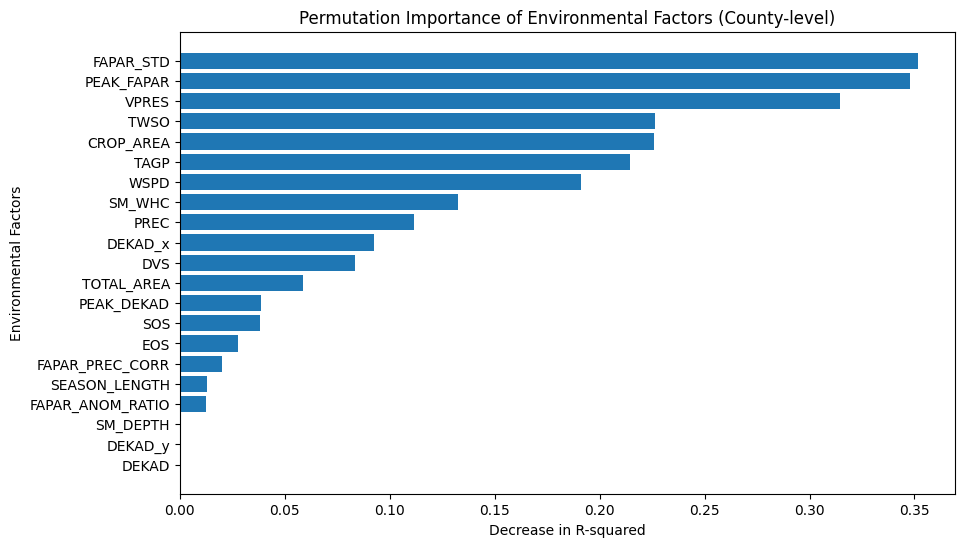

In [40]:
# Environmental Factors Influence on Prediction Performance
# This section identifies which environmental variables most strongly influence the model's predictions


from sklearn.inspection import permutation_importance

# Load the trained county-level model
model = tf.keras.models.load_model(os.path.join(base, "nn_county_multi_input.keras"))

# Assume X_test, y_test, and trained model are already available
# X_test: DataFrame of environmental features
# y_test: True labels
# model: trained ML model

result = permutation_importance(
    model,
    X_test_scaled, # Use scaled features as the model was trained on scaled data
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='r2' # Changed to r2 for regression task
)

importance_df = pd.DataFrame({
    'Environmental Factor': X_test.columns, # Use original column names for readability
    'Mean Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values(by='Mean Importance', ascending=False)

print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Environmental Factor'], importance_df['Mean Importance'])
plt.xlabel('Decrease in R-squared') # Updated label to reflect 'r2' scoring
plt.ylabel('Environmental Factors')
plt.title('Permutation Importance of Environmental Factors (County-level)') # Clarified title
plt.gca().invert_yaxis()
plt.show()

# Interpretation tip:
# Higher mean importance indicates stronger influence on prediction performance